In [168]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import ast
import datetime

# Load the data

## Metadata

In [220]:
metadata = pd.read_csv('movies_dataset/movies_metadata.csv')

Let's precise what each column corresponds to. We have:
<ul>
    <li>adult: specify if the film is X-Rated/Adults only or not<\li>
    <li>belongs_to_collection: specify if the movie is part of a series of movies (such as the Harry Potter franchise)<\li>
    <li>poster_path: directly gives the path to the jpg poster image<\li>
    <li>budget: budget of the movie (in dollars)<\li>
    <li>revenue: revenue of the movie (in dollars)<\li>
    <li>genres: list of genres the movie is associated with <\li>
    <li>homepage: url to the homepage of the movie (if existing)<\li>
    <li>imdb_id: id in the IMDB database<\li>
    <li>original_language: language the movie was originally shot in<\li>
    <li>overview: short description of the story<\li>
    <li>release_date: release date of the movie (to be splitted in day, month and year for further analysis)<\li>
    <li>runtime: duration of the movie (in minutes)<\li>
    <li>spoken_languages: list of spoken languages in the movie<\li>
    <li>status: status of the film (Released, Rumored, Post Production, In Production, Planned, Canceled)<\li>
    <li>tagline: tagline of the movie (if existing)<\li>
    <li>title: title of the movie (in English)<\li>
    <li>original_title: original title of the movie (in the original language)<\li>
    <li>vote_average: average of all votes for the movie<\li>
    <li>vote_count: number of votes from which the vote_average is computed<\li>
    <li>popularity: popularity score of the movie<\li>
    <li>production_companies: list of companies that have produced the film<\li>
<\ul>

In [170]:
print('In the dataset there are %d movies.' %len(metadata))

In the dataset there are 45466 movies.


### Temporal dimension

Let's extract from the release_date feature the weekday, month and year for each movie. We will use the datetime function weekday() to extract the corresponding day of the week (as it is far more interesting than the actual number) and directly convert the month number to the corresponding name (01 to 'Jan' for instance).

In [171]:
month_order = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
day_order = ['Mon', 'Tue', 'Wed', 'Thu', 'Fri', 'Sat', 'Sun']

In [172]:
def get_year(x):
    try:
        year = int(str(x).split('-')[0])
        #Check if year is larger than 1800 since some values do not make sense (a 1 has been found)
        if year < 1800:
            year = np.nan
        return year
    except:
        return np.nan

In [173]:
def get_month(x):
    try:
        return month_order[int(str(x).split('-')[1]) - 1]
    except:
        return np.nan

In [174]:
def get_day(x):
    try:
        year, month, day = (int(i) for i in x.split('-')) 
        answer = datetime.date(year, month, day).weekday()
        return day_order[answer]
    except:
        return np.nan

In [175]:
metadata['year'] = metadata.release_date.map(lambda x: get_year(x))
metadata['month'] = metadata.release_date.map(lambda x: get_month(x))
metadata['weekday'] = metadata.release_date.map(lambda x: get_day(x))

In [176]:
year_min = metadata.year.min()
year_max = metadata.year.max()
print('The first movie in the dataset has been released in %d and the last in %d.' %(year_min, year_max))

The first movie in the dataset has been released in 1874 and the last in 2020.


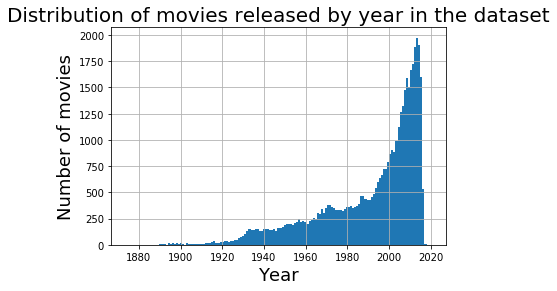

In [177]:
metadata.year.hist(bins = int(year_max - year_min + 1))
plt.title('Distribution of movies released by year in the dataset', fontsize = 20)
plt.xlabel('Year', fontsize = 18)
plt.ylabel('Number of movies', fontsize = 18)
plt.show()

### Adult

Let's observe the "adult" column. It seems only 9 movies are rated as X-Rated/Adults only, with three other movies containing erronous information (probably corresponding to the tagline of the film).

In [178]:
metadata.adult.value_counts()

False                                                                                                                             45454
True                                                                                                                                  9
 - Written by Ørnås                                                                                                                   1
 Rune Balot goes to a casino connected to the October corporation to try to wrap up her case once and for all.                        1
 Avalanche Sharks tells the story of a bikini contest that turns into a horrifying affair when it is hit by a shark avalanche.        1
Name: adult, dtype: int64

### Franchises

Since the belongs_to_collection column is cast to str, let's use the json library to load it to a dict and extract the name of the franchise (the other informations can be droped since the poster path is also stored in the dedicated column).

In [179]:
def extract_collection(collection):
    collection_name = 'Not a franchise!'
    if collection != 'nan': 
        collection_dict = json.loads(collection.replace('\'', '\"'))
        collection_name = collection_dict['name']
    return collection_name

DOESN'T WORK!!!

In [182]:
#metadata['belongs_to_collection'] = metadata['belongs_to_collection'].map(lambda x: extract_collection(str(x)))

### Budget and revenues

Let's observe the revenue and budget colums. We notice a lot of the values for the revenue and the budget are 0. This in fact represents the fact that we do not have information for those movies budget, therefore we will replace them by NaN values (to not skew further computations towards 0).

In [183]:
metadata.replace(0, np.nan, inplace = True)

The same process is applied to the budget, after converting it to numeric values, since some unclean values make Pandas cast it as a generic object.

In [184]:
metadata['budget'] = pd.to_numeric(metadata['budget'], errors='coerce')
metadata['budget'].replace(0, np.nan, inplace = True)

In [185]:
print('Out of %d movies, %d do not have a budget.' %(len(metadata), len(metadata[metadata['budget'].isnull()])))
print('Out of %d movies, %d do not have a budget.' %(len(metadata), len(metadata[metadata['revenue'].isnull()])))

Out of 45466 movies, 36576 do not have a budget.
Out of 45466 movies, 38058 do not have a budget.


We are missing budget and revenue values for a lot of movies, but still we have informations about these features on more than 7000 movies.

### Poster

Let's add the full path to the jpg poster images (as an image component, easier to handle later on our website).

In [186]:
base_poster_url = 'http://image.tmdb.org/t/p/w185/'
metadata['poster_path'] = "<img src='" + base_poster_url + metadata['poster_path'] + "' style='height:100px;'>"

### Genres

In [224]:
metadata.genres.iloc[0]

"[{'id': 16, 'name': 'Animation'}, {'id': 35, 'name': 'Comedy'}, {'id': 10751, 'name': 'Family'}]"

### Title, overview and taglines

Let's ensure these are all in str type for further analyses.

In [221]:
metadata['title'] = metadata['title'].astype('str')
metadata['overview'] = metadata['overview'].astype('str')
metadata['tagline'] = metadata['tagline'].astype('str')

### Production countries

In [227]:
metadata['production_countries'].iloc[10]

"[{'iso_3166_1': 'US', 'name': 'United States of America'}]"

## Credits

In [10]:
credits = pd.read_csv('movies_dataset/credits.csv')

## Ratings

In [12]:
ratings = pd.read_csv('movies_dataset/ratings.csv')